In [1]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nes_py-0.2.6-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: nes-py
    Found existing installation: nes-py 8.2.1
    Uninstalling nes-py-8.2.1:
      Successfully uninstalled nes-py-8.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym-super-mario-bros 7.4.0 requires nes-py>=8.1.4, but you have nes-py 0.2.6 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: nes-py
    Found existing installation: nes-py 0.2.6
    Uninstalling nes-py-0.2.6:
      Successfully uninstalled nes-py-0.2.6


In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import pickle
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections
import cv2
import matplotlib.pyplot as plt
from IPython import display
import time
%matplotlib inline

In [2]:
class MaxAndSkipEnv(gym.Wrapper):
  def __init__(self, env=None, skip=4):
      super(MaxAndSkipEnv, self).__init__(env)
      self._obs_buffer = collections.deque(maxlen=2)
      self._skip = skip

  def step(self, action):
    total_reward = 0.0
    done = None
    for _ in range(self._skip):
      obs, reward, done, info = self.env.step(action)
      self._obs_buffer.append(obs)
      total_reward += reward
      if done:
        break
    max_frame = np.max(np.stack(self._obs_buffer), axis=0)
    return max_frame, total_reward, done, info

  def reset(self):
    self._obs_buffer.clear()
    obs = self.env.reset()
    self._obs_buffer.append(obs)
    return obs

class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [3]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env)  # Wraps the environment so that frames are grayscale
env.reset()

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [5]:
class Deep_Q_Learning(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(Deep_Q_Learning, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        output = self.conv(torch.zeros(1, *shape))
        return int(np.prod(output.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_mem, batch_size, gamma, lr,
                 epsilon_greedy, epsilon_min, epsilon_decay, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
       
        self.local_net = Deep_Q_Learning(state_space, action_space).to(self.device)
        self.target_net = Deep_Q_Learning(state_space, action_space).to(self.device)
            
        if self.pretrained:
            self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
            self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
        self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
        self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
        self.step = 0

        # Create memory
        self.max_mem = max_mem
        if self.pretrained:
            #self.State_Memory = torch.load("State_Memory.pt")
            self.State_Memory = torch.zeros(max_mem, *self.state_space)
            self.Action_Memory = torch.load("Action_Memory.pt")
            self.Reward_Memory = torch.load("Reward_Memory.pt")
            #self.State2_Memory = torch.load("State2_Memory.pt")
            self.State2_Memory = torch.zeros(max_mem, *self.state_space)
            self.Done_Memory = torch.load("Done_Memory.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.State_Memory = torch.zeros(max_mem, *self.state_space)
            self.Action_Memory = torch.zeros(max_mem, 1)
            self.Reward_Memory = torch.zeros(max_mem, 1)
            self.State2_Memory = torch.zeros(max_mem, *self.state_space)
            self.Done_Memory = torch.zeros(max_mem, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.mem_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.epsilon_greedy = epsilon_greedy
        self.exploration_rate = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def remember(self, state, action, reward, state2, done):
        self.State_Memory[self.ending_position] = state.float()
        self.Action_Memory[self.ending_position] = action.float()
        self.Reward_Memory[self.ending_position] = reward.float()
        self.State2_Memory[self.ending_position] = state2.float()
        self.Done_Memory[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_mem  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_mem)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.mem_size)
        
        STATE = self.State_Memory[idx]
        ACTION = self.Action_Memory[idx]
        REWARD = self.Reward_Memory[idx]
        STATE2 = self.State2_Memory[idx]
        DONE = self.Done_Memory[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])

        # Local net is used for the policy
        return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()


    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.step % self.copy == 0:
            self.copy_model()

        if self.mem_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
        target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

        current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.epsilon_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.epsilon_min)

In [6]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_mem=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     epsilon_greedy=1.0,
                     epsilon_min=0.02,
                     epsilon_decay=0.99,
                     pretrained=pretrained)
    
    num_episodes = 10000
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor(np.array([state]))
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                #show_state(env, ep_num)
                pass
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor(np.array([state_next]))
            reward = torch.tensor(np.array([reward])).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                print("state", state)
                print("action", action)
                print("reward", reward)
                print("state_next", state_next)
                print("terminal", terminal)
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        
        torch.save(agent.local_net.state_dict(), "dq1.pt")
        torch.save(agent.target_net.state_dict(), "dq2.pt")
        torch.save(agent.State_Memory,  "State_Memory.pt")
        torch.save(agent.Action_Memory, "Action_Memory.pt")
        torch.save(agent.Reward_Memory, "Reward_Memory.pt")
        torch.save(agent.State2_Memory, "State2_Memory.pt")
        torch.save(agent.Done_Memory,   "Done_Memory.pt")
    
    env.close()
    
    if num_episodes > 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + 
                 np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()

In [7]:
def give_agent(training_mode, pretrained):
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_mem=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     epsilon_greedy=1.0,
                     epsilon_min=0.02,
                     epsilon_decay=0.99,
                     pretrained=pretrained)
    print(agent.Action_Memory.shape)
    return env, agent

In [8]:
envi, mario_agent = give_agent(False, True)

torch.Size([30000, 1])


In [9]:
count = 0
reward_counter = 0
begin = 0
max_reward = 0
max_begin = 0
max_end = 0
num = 0
for i in mario_agent.Done_Memory:
  reward_counter += mario_agent.Reward_Memory[count].tolist()[0]
  if i == torch.Tensor([1.0]):
    num += 1
    if reward_counter > max_reward:
      max_reward = reward_counter
      max_begin = begin
      max_end = count
    begin = count
    reward_counter = 0
  count += 1

In [10]:
action_list = []
action_counter = max_begin + 1
reward_counter = 0
while action_counter <= max_end:
  this_action = int(mario_agent.Action_Memory[action_counter].tolist()[0])
  reward_counter += mario_agent.Reward_Memory[action_counter].tolist()[0]
  action_list.append(this_action)
  action_counter += 1

In [12]:
def test_model():
    agent = mario_agent 

    env = gym.wrappers.Monitor(envi, "./gym-results", force=True)
    env.reset()
    state = env.reset()
    state = torch.Tensor(np.array([state]))
    total_reward = 0
    steps = 0
    while steps <= max_end:
        show_state(env, max_begin)

        action = action_list[steps]
        steps += 1
        
        state_next, reward, terminal, info = env.step(action)
        total_reward += reward
        state_next = torch.Tensor(np.array([state_next]))
        reward = torch.tensor(np.array([reward])).unsqueeze(0)
        terminal = torch.tensor([int(terminal)]).unsqueeze(0)            
        state = state_next
        if terminal:
            break
    print("Total reward after episode {} is {}".format(max_begin + 1, total_reward))  

Total reward after episode 23034 is 3069.0


Exception ignored in: <function Monitor.__del__ at 0x7fa6a314a4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 131, in close
    super(Monitor, self).close()
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 243, in close
    return self.env.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 243, in close
    return self.env.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 243, in close
    return self.env.close()
  [Previous line repeated 5 more times]
  File "/usr/local/lib/python3.7/dist-packages/nes_py/nes_env.py", line 346, in close
    raise ValueError('env has already been closed.')
ValueError: env has already been closed.


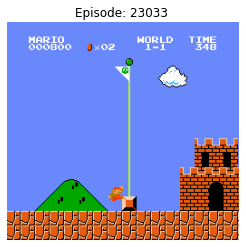

In [13]:
#run(training_mode=False, pretrained=True)
test_model()

